In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [4]:
import xgboost as xgb
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

In [5]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, SpatialDropout1D
from keras.layers import LSTM

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [7]:
train_data = pd.read_csv('dataset/twitter_training.csv', header=None, names=['ID', 'Information', 'Sentiment', 'Text'])
test_data = pd.read_csv('dataset/twitter_validation.csv', header=None, names=['ID', 'Information', 'Sentiment', 'Text'])

In [8]:
train_data.head()

,ID,Information,Sentiment,Text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [9]:
train_data.shape

(74682, 4)

In [10]:
test_data.head()

,ID,Information,Sentiment,Text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [11]:
test_data.shape

(1000, 4)

In [12]:
train_data['Sentiment'].value_counts()

Sentiment
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

In [13]:
train_data['Sentiment'] = train_data['Sentiment'].replace('Irrelevant', 'Neutral')
train_data['Sentiment'].value_counts()

Sentiment
Neutral     31308
Negative    22542
Positive    20832
Name: count, dtype: int64

In [14]:
train_data.isnull().sum()

ID               0
Information      0
Sentiment        0
Text           686
dtype: int64

In [15]:
#Drop rows where 'Text' column contains NaN value
train_data = train_data.dropna(subset=['Text'])

In [16]:
train_data.isnull().sum()

ID             0
Information    0
Sentiment      0
Text           0
dtype: int64

In [39]:
test_data['Sentiment'].value_counts()

Sentiment
Neutral       285
Positive      277
Negative      266
Irrelevant    172
Name: count, dtype: int64

In [40]:
test_data['Sentiment'] = test_data['Sentiment'].replace('Irrelevant', 'Neutral')
test_data['Sentiment'].value_counts()

Sentiment
Neutral     457
Positive    277
Negative    266
Name: count, dtype: int64

In [41]:
test_data.isnull().sum()

ID                   0
Information          0
Sentiment            0
Text                 0
Preprocessed_Text    0
dtype: int64

In [42]:
#Drop rows where 'Text' column contains NaN value
test_data = test_data.dropna(subset=['Text'])

In [43]:
test_data.isnull().sum()

ID                   0
Information          0
Sentiment            0
Text                 0
Preprocessed_Text    0
dtype: int64

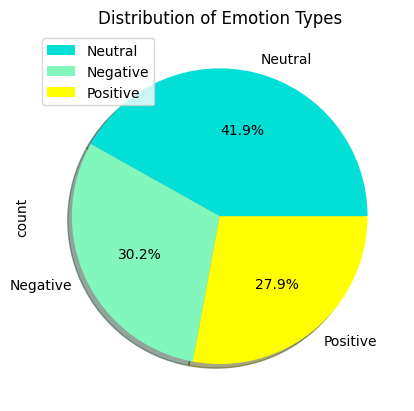

In [17]:
type_counts = train_data['Sentiment'].value_counts()
color = ['#01DFD7', '#81F7BE', '#FFFF00' ]
type_counts.plot(kind='pie', autopct='%1.1f%%', labels=type_counts.index, colors=color, shadow=True)
plt.title('Distribution of Emotion Types')
plt.legend()

In [18]:
train_data['Text'][0]

'im getting on borderlands and i will murder you all ,'

In [20]:
# nltk.download('stopwords')

In [21]:
# Tokenization of Text
tokenizer = ToktokTokenizer()

#Setting English stopwords
stopword_list = nltk.corpus.stopwords.words('english')

In [22]:
def preprocess_text(text):
    text = re.sub(r'\$\w*', '', text)
    text = re.sub(r'^RT[\s]+', '', text)    
    text = re.sub(r'https?://[^\s\n\r]+', '', text)    
    text = re.sub(r'#', '', text)    
    text = re.sub(r'http\S+', '', text)    
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

In [23]:
train_data['Text'] = train_data['Text'].apply(preprocess_text)
test_data['Text'] = test_data['Text'].apply(preprocess_text)

In [24]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

In [25]:
train_data['Text'] = train_data['Text'].apply(simple_stemmer)
test_data['Text'] = test_data['Text'].apply(simple_stemmer)

In [26]:
stop = set(stopwords.words('english'))
print(stop)

{'are', 'll', 'few', 'not', 'just', 'up', 'while', 'some', 'own', 'doing', 'any', 'both', 'after', 't', 'until', 'through', 'wouldn', 'only', 'have', 'ours', 'itself', 'then', 'why', 'yourself', 'against', 'he', 's', 'its', 'were', "mustn't", 'of', 'for', 'between', 'as', 'm', 'was', 'your', "couldn't", 'doesn', "shouldn't", 'same', 'didn', 'it', 'ain', 'himself', "needn't", 'with', 'has', 'than', 'she', "hasn't", 'wasn', 'but', "didn't", 'them', 'each', 'further', "you're", 'those', 'hasn', 'during', 'will', "weren't", 'off', 'does', 'their', 'needn', 'ma', 'i', 'down', 'couldn', 'haven', "mightn't", 'mightn', 'having', 'we', 'over', 'herself', 'again', 'who', 'they', 'on', 'our', 'you', 'into', "hadn't", 'out', 'hers', 'isn', 'yours', 'be', 'this', 'under', 'how', 'here', 'there', 'theirs', 'did', "that'll", 'if', 'too', 'whom', "aren't", "it's", 'aren', 'a', 'an', 'above', 'in', 'which', 'to', 'once', "she's", 'and', 'being', 'shan', 're', 'from', 'won', 'can', 'all', 'me', "you've"

In [27]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [28]:
train_data['Preprocessed_Text'] = train_data['Text'].apply(remove_stopwords)
test_data['Preprocessed_Text'] = test_data['Text'].apply(remove_stopwords)

In [29]:
train_data.tail()

,ID,Information,Sentiment,Text,Preprocessed_Text
74677,9200,Nvidia,Positive,just realiz that the window partit of my mac i...,realiz window partit mac like year behind nvid...
74678,9200,Nvidia,Positive,just realiz that my mac window partit is year ...,realiz mac window partit year behind nvidia dr...
74679,9200,Nvidia,Positive,just realiz the window partit of my mac is now...,realiz window partit mac year behind nvidia dr...
74680,9200,Nvidia,Positive,just realiz between the window partit of my ma...,realiz window partit mac like year behind nvid...
74681,9200,Nvidia,Positive,just like the window partit of my mac is like ...,like window partit mac like year behind driver...


In [30]:
test_data.head()

,ID,Information,Sentiment,Text,Preprocessed_Text
0,3364,Facebook,Irrelevant,i mention on facebook that i wa struggl for mo...,mention facebook wa struggl motiv go run day h...
1,352,Amazon,Neutral,bbc new amazon boss jeff bezo reject claim com...,bbc new amazon boss jeff bezo reject claim com...
2,8312,Microsoft,Negative,microsoft whi do i pay for word when it functi...,microsoft whi pay word function poorli samsung...
3,4371,CS-GO,Negative,csgo matchmak is so full of closet hack it a t...,csgo matchmak full closet hack truli aw game
4,4433,Google,Neutral,now the presid is slap american in the face th...,presid slap american face realli commit unlaw ...


In [31]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)

tfidf_train_features = tfidf_vectorizer.fit_transform(train_data['Preprocessed_Text'])

tfidf_test_features = tfidf_vectorizer.transform(test_data['Preprocessed_Text'])

print(tfidf_train_features.shape)
print(tfidf_test_features.shape)

(73996, 10000)
(1000, 10000)


In [44]:
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_data['Sentiment'])
test_labels_encoded = label_encoder.transform(test_data['Sentiment'])

print(train_labels_encoded.shape)
print(test_labels_encoded.shape)

(73996,)
(1000,)


In [46]:
unique_values = np.unique(train_labels_encoded)
print("Train Label Encoded ",unique_values)

unique_values = np.unique(test_labels_encoded)
print("Test Label Encoded ",unique_values)

Train Label Encoded  [0 1 2]
Test Label Encoded  [0 1 2]


In [52]:
for value in unique_values:
    print(value, "means", label_encoder.inverse_transform([value])[0])

0 means Negative
1 means Neutral
2 means Positive


In [53]:
#Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

xgb_classifier.fit(tfidf_train_features,train_labels_encoded)

test_prediction_xgb_encoded = xgb_classifier.predict(tfidf_test_features)

test_prediction_xgb = label_encoder.inverse_transform(test_prediction_xgb_encoded)

In [55]:
accuracy_xgb = accuracy_score(test_data['Sentiment'], test_prediction_xgb)
print(f"XGBoost Accuracy:{accuracy_xgb*100:.2f}%")

XGBoost Accuracy:77.00%


In [56]:
print("XGBoost Confusion Matrix:")
print(confusion_matrix(test_data['Sentiment'], test_prediction_xgb))

print("XGBoost Classification Report:")
print(classification_report(test_data['Sentiment'], test_prediction_xgb))

XGBoost Confusion Matrix:
[[194  61  11]
 [ 39 394  24]
 [ 12  83 182]]
XGBoost Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.73      0.76       266
     Neutral       0.73      0.86      0.79       457
    Positive       0.84      0.66      0.74       277

    accuracy                           0.77      1000
   macro avg       0.79      0.75      0.76      1000
weighted avg       0.78      0.77      0.77      1000



In [65]:
#Logistic Regression
lr = LogisticRegression(penalty='l2', max_iter=500, C=1)

lr.fit(tfidf_train_features, train_labels_encoded)

test_prediction_lr_encoded = lr.predict(tfidf_test_features)
test_prediction_lr = label_encoder.inverse_transform(test_prediction_lr_encoded)

In [66]:
accuracy_lr = accuracy_score(test_data['Sentiment'], test_prediction_lr)
print(f"Logistic Regression Accuracy:{accuracy_lr*100:.2f}%")

Logistic Regression Accuracy:85.60%


In [67]:
print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(test_data['Sentiment'], test_prediction_lr))

print("Logistic Regression Classification Report:")
print(classification_report(test_data['Sentiment'], test_prediction_lr))

Logistic Regression Confusion Matrix:
[[233  22  11]
 [ 43 394  20]
 [ 10  38 229]]
Logistic Regression Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.88      0.84       266
     Neutral       0.87      0.86      0.86       457
    Positive       0.88      0.83      0.85       277

    accuracy                           0.86      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.86      0.86      0.86      1000



In [69]:
#SVM
svm = SGDClassifier(loss='hinge', max_iter=500, random_state=42)

svm.fit(tfidf_train_features, train_labels_encoded)

test_prediction_svm_encoded = svm.predict(tfidf_test_features)

test_prediction_svm = label_encoder.inverse_transform(test_prediction_svm_encoded)

In [70]:
accuracy_svm = accuracy_score(test_data['Sentiment'], test_prediction_svm)
print(f"SGD Classifier Accuracy:{accuracy_svm*100:.2f}%")

SGD Classifier Accuracy:77.70%


In [71]:
print("SGD Classifier Confusion Matrix:")
print(confusion_matrix(test_data['Sentiment'], test_prediction_svm))

print("SGD Classifier Classification Report:")
print(classification_report(test_data['Sentiment'], test_prediction_svm))

SGD Classifier Confusion Matrix:
[[207  42  17]
 [ 57 367  33]
 [ 21  53 203]]
SGD Classifier Classification Report:
              precision    recall  f1-score   support

    Negative       0.73      0.78      0.75       266
     Neutral       0.79      0.80      0.80       457
    Positive       0.80      0.73      0.77       277

    accuracy                           0.78      1000
   macro avg       0.77      0.77      0.77      1000
weighted avg       0.78      0.78      0.78      1000



In [72]:
#Naive Bayes
mnb = MultinomialNB()

mnb.fit(tfidf_train_features, train_labels_encoded)

test_prediction_mnb_encoded = mnb.predict(tfidf_test_features)
test_prediction_mnb = label_encoder.inverse_transform(test_prediction_mnb_encoded)

In [73]:
accuracy_mnb = accuracy_score(test_data['Sentiment'], test_prediction_mnb)
print(f"Multinomial NB Accuracy:{accuracy_mnb*100:.2f}%")

Multinomial NB Accuracy:80.00%


In [74]:
print("Multinomial NB Confusion Matrix:")
print(confusion_matrix(test_data['Sentiment'], test_prediction_mnb))

print("Multinomial NB Classification Report:")
print(classification_report(test_data['Sentiment'], test_prediction_mnb))

Multinomial NB Confusion Matrix:
[[209  41  16]
 [ 53 377  27]
 [ 24  39 214]]
Multinomial NB Classification Report:
              precision    recall  f1-score   support

    Negative       0.73      0.79      0.76       266
     Neutral       0.82      0.82      0.82       457
    Positive       0.83      0.77      0.80       277

    accuracy                           0.80      1000
   macro avg       0.80      0.79      0.79      1000
weighted avg       0.80      0.80      0.80      1000



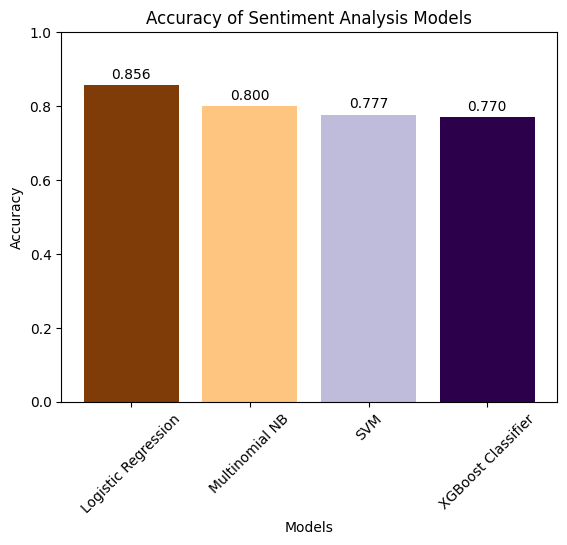

In [101]:
models = ['Logistic Regression', 'Multinomial NB', 'SVM', 'XGBoost Classifier']
accuracies = [accuracy_lr, accuracy_mnb, accuracy_svm, accuracy_xgb]

plt.bar(models, accuracies, color=plt.cm.PuOr(np.linspace(0, 1, len(models))))
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy of Sentiment Analysis Models')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Adding annotations to each bar
for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy + 0.01, f'{accuracy:.3f}', ha='center', va='bottom')

plt.show()

In [95]:
positive_train_reviews = train_data[train_data['Sentiment']=='Positive']['Text']

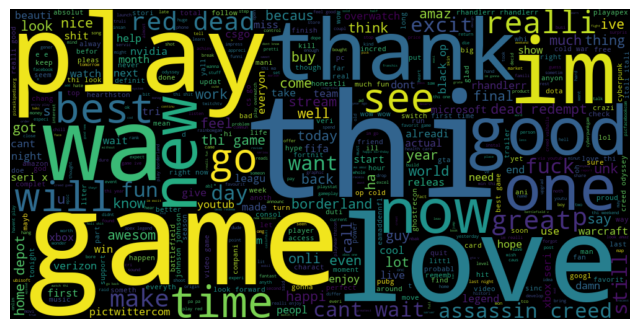

In [97]:
plt.figure(figsize=(8,8))
positive_text = " ".join(positive_train_reviews[:])

WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
positive_words = WC.generate(positive_text)

plt.imshow(positive_words, interpolation='bilinear')
plt.axis('off')
plt.show()

In [98]:
negative_train_reviews = train_data[train_data['Sentiment']=='Negative']['Text']

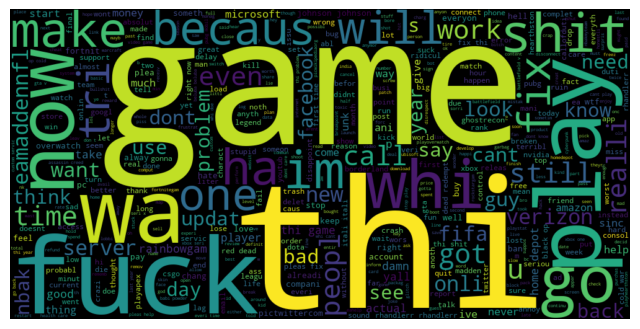

In [99]:
plt.figure(figsize=(8,8))
negative_text = " ".join(negative_train_reviews[:])

WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
negative_words = WC.generate(negative_text)

plt.imshow(negative_words, interpolation='bilinear')
plt.axis('off')
plt.show()

In [104]:
#Deep learning
df1 = pd.read_csv('dataset/twitter_training.csv', header=None, names=['ID', 'Information', 'Sentiment', 'Text'])
df2 = pd.read_csv('dataset/twitter_validation.csv', header=None, names=['ID', 'Information', 'Sentiment', 'Text'])

In [107]:
columns_to_drop = ['ID', 'Information']
df1 = df1.drop(columns=columns_to_drop, errors = 'ignore')
df2 = df2.drop(columns=columns_to_drop, errors = 'ignore')

In [112]:
df = pd.concat([df1,df2])
df.sample(5)

,Sentiment,Text
48972,Negative,@EAHelp good evening i can't access fifa it di...
13237,Positive,"It looks really good, except for 2 little thin..."
32198,Positive,I downloaded the Champions League and now I ha...
63591,Negative,NaN
46712,Irrelevant,What a joke. MATTER LIVES!


In [113]:
df['Sentiment'] = df['Sentiment'].replace('Irrelevant', 'Neutral')
df['Sentiment'].value_counts()

Sentiment
Neutral     31765
Negative    22808
Positive    21109
Name: count, dtype: int64

In [114]:
df.dropna(subset=['Text'], inplace=True)
df.isnull().sum()

Sentiment    0
Text         0
dtype: int64

In [117]:
df.duplicated().sum()

4818

In [118]:
df.drop_duplicates(inplace=True)
df['Sentiment'].value_counts()

Sentiment
Neutral     29578
Negative    21329
Positive    19271
Name: count, dtype: int64

In [119]:
def preprocess_text(text):
    text = re.sub(r'@\w+', '', text)
    
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F" # Emoticons
        "\U0001F300-\U0001F5FF" # Symbols & pictographs
        "\U0001F680-\U0001F6FF" # Transport & map symbols
        "\U0001F700-\U0001F77F" # Alchemical symbols
        "\U0001F780-\U0001F7FF" # Geometric shapes
        "\U0001F800-\U0001F8FF" # Miscellaneous Symbols and Arrows
        "\U0001F900-\U0001F9FF" # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F" # Extended-A
        "\U0001FA70-\U0001FAFF" # Extended-B
        "\U00002702-\U000027B0" # Dingbats
        "\U000024C2-\U0001F251"
        "]+"
    )
    text = emoji_pattern.sub(r'', text)
    
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    return text.strip()

In [120]:
df['Text'] = df['Text'].apply(preprocess_text)
df.head()

,Sentiment,Text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you all
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [123]:
df = df[df['Text'].apply(lambda x: len(x.split()) <= 70)]

# Resetting the index after dropping rows
df.reset_index(drop=True, inplace=True)
df.sample(5)

,Sentiment,Text
25976,Negative,Trying to cover up their shitty abusive company
39545,Negative,Even tae oh pubg I wont ever installing it hah...
22849,Neutral,You are about ten seconds away from your Reich...
24928,Positive,yes I LOVED THIS GAME this game the combat the...
12296,Negative,The Man hasnt even done down anything yet wtfff


In [137]:
tokenizer = Tokenizer()

text = df['Text'].tolist()
tokenizer.fit_on_texts(text)

In [138]:
sequences = tokenizer.texts_to_sequences(text)

print('The max length in Text is:',max([len(x) for x in sequences]))
print('The Unique word in the Text are:',len(tokenizer.word_index))

The max length in Text is: 70
The Unique word in the Text are: 40758


In [126]:
input_pad_sequences = pad_sequences(sequences, maxlen=70, padding='pre')

In [127]:
X = input_pad_sequences
y = df['Sentiment']

In [128]:
#label encoder
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y)

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(56125, 70)
(14032, 70)
(56125, 3)
(14032, 3)


In [142]:
#Neural Network

from keras.initializers import glorot_normal

model = Sequential()
model.add(Embedding(40759, 200, input_length=70, mask_zero=True, embeddings_initializer=glorot_normal()))

model.add(LSTM(100, return_sequences=True,dropout=0.6 ))
model.add(LSTM(100, return_sequences=True,dropout=0.6 ))
model.add(LSTM(100, return_sequences=True,dropout=0.6 ))
model.add(LSTM(100))

model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

In [143]:
# Compiling the model
model.compile(optimizer= 'adam',loss= 'categorical_crossentropy',metrics= ['accuracy'])

In [144]:
# Model Training
history = model.fit(X_train, y_train,epochs=10, batch_size=32, validation_data=(X_test,y_test))

Epoch 1/10
1754/1754 [==============================] - 506s 279ms/step - loss: 0.7496 - accuracy: 0.6705 - val_loss: 0.5145 - val_accuracy: 0.7982
Epoch 2/10
1754/1754 [==============================] - 452s 258ms/step - loss: 0.3933 - accuracy: 0.8524 - val_loss: 0.3699 - val_accuracy: 0.8585
Epoch 3/10
1754/1754 [==============================] - 456s 260ms/step - loss: 0.2644 - accuracy: 0.9038 - val_loss: 0.3242 - val_accuracy: 0.8788
Epoch 4/10
1754/1754 [==============================] - 460s 262ms/step - loss: 0.1999 - accuracy: 0.9274 - val_loss: 0.2982 - val_accuracy: 0.8926
Epoch 5/10
1754/1754 [==============================] - 527s 300ms/step - loss: 0.1612 - accuracy: 0.9418 - val_loss: 0.3113 - val_accuracy: 0.8972
Epoch 6/10
1754/1754 [==============================] - 576s 329ms/step - loss: 0.1339 - accuracy: 0.9504 - val_loss: 0.3031 - val_accuracy: 0.9013
Epoch 7/10
1754/1754 [==============================] - 463s 264ms/step - loss: 0.1173 - accuracy: 0.9578 - val_

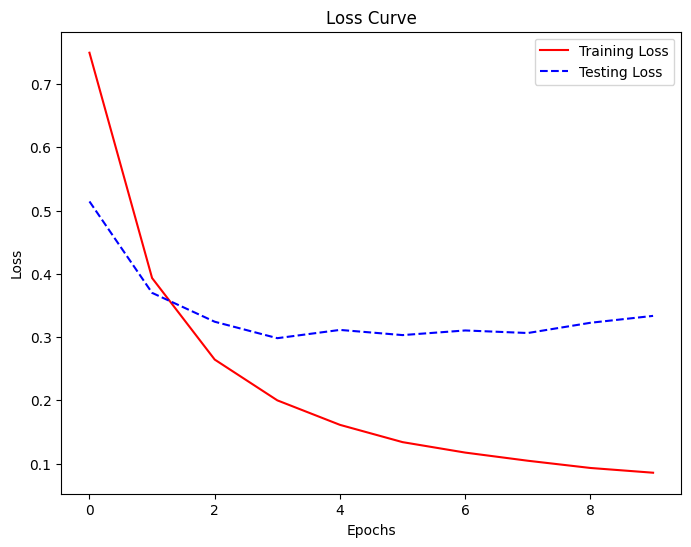

In [145]:
# Loss Curves
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'],color='red')
plt.plot(history.history['val_loss'],ls='--',color='blue')
plt.legend(['Training Loss','Testing Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

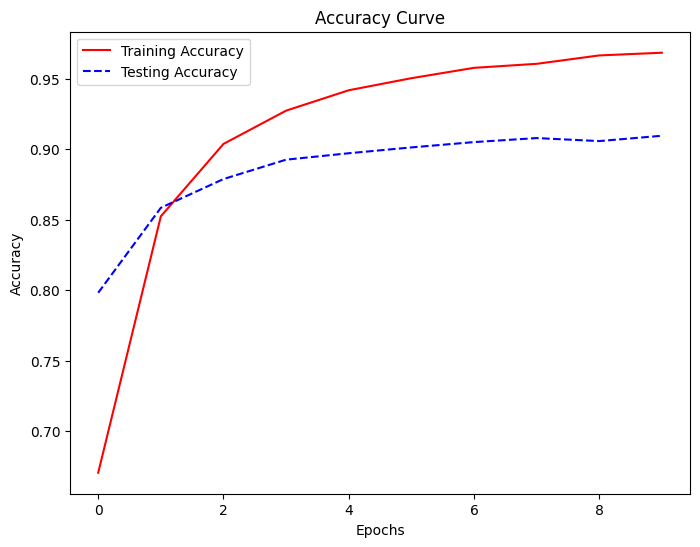

In [146]:
# Accuracy Curves
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'],color='red')
plt.plot(history.history['val_accuracy'],ls='--',color='blue')
plt.legend(['Training Accuracy','Testing Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.show()

In [148]:
# Save the trained model to the native Keras format
model.save('trained_sentiment_analysis_model.keras')

In [149]:
from keras.models import load_model

# Load the saved model
loaded_model = load_model('trained_sentiment_analysis_model.keras')